In [2]:
!nvidia-smi

Mon Dec  9 15:25:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install biopython
!pip install transformers

     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 368kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 44.1MB/s 
     |████████████████████████████████| 860kB 47.9MB/s 
     |████████████████████████████████| 645kB 47.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=4a477aef512c5c0ead3e6e5a76ddb6f1a7b204d9361a7c8d8b2a3066ef92ac1f
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [5]:
import os
import sys
import pickle
import torch
import numpy as np
import torch.optim as optim
# from transformers import BertConfig, BertModel, BertForMaskedLM
from transformers import GPT2Config, GPT2Model, GPT2LMHeadModel
from Bio import SeqIO
from Bio.Data import CodonTable

from IPython.display import clear_output

In [0]:
# load genes and fake ORFs
d = "drive/My Drive/Colab Notebooks/smaug/data"
gene_ORF_path = os.path.join(d, "ecoli_MG1655_geneORFs.pkl")
fake_ORF_path = os.path.join(d, "ecoli_MG1655_fakeORFs.pkl")
# gene_ORF_path = os.path.join(d, "Staphylococcus_geneORFs.pkl")
# fake_ORF_path = os.path.join(d, "Staphylococcus_fakeORFs.pkl")

with open(gene_ORF_path, 'rb') as f:
    gene_aa_filtered = pickle.load(f)
with open(fake_ORF_path, 'rb') as f:
    fake_aa = pickle.load(f)

gene_aa_filtered = [x for x in gene_aa_filtered if len(x) > 40]
fake_aa = [x for x in fake_aa if len(x) > 40] # already filtered for length at creation time

In [0]:
def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":0, # get rid of these
             "B":0,
             "*":0}
    tokenized = torch.tensor([table[aa] for aa in aa_seq])
    return tokenized

In [8]:
# split long ORFs into shingles

# TODO: this was done in time crunch, should not be done like this. Redo
SHINGLE_STEP = 20
SHINGLE_LENGTH = 40 # shingle length should be the same as trained model window size

ORF_shingled = []
for i, ORFseq in enumerate(gene_aa_filtered):
    if i%1000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ORF_shingled_temp.append(shingle_int)
    
    ORF_shingled.append(ORF_shingled_temp)
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ORF_shingled]
combined_shape = [len(x) for x in combined]

ORF_flat = torch.cat(combined, dim=0)

# ARFs
ARF_shingled = []
for i, ARFseq in enumerate(fake_aa):
    if i%1000==0:
        print(i)
    ARF_shingled_temp = []
    while True:
        shingle = ARFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ARF_shingled_temp.append(shingle_int)
        if len(ARFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ARFseq = ARFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ARFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ARF_shingled_temp.append(shingle_int)
    
    ARF_shingled.append(ARF_shingled_temp)
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ARF_shingled]
combined_shape = [len(x) for x in combined]

ARF_flat = torch.cat(combined, dim=0)

0
1000
2000
3000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [9]:
# split into training and test with gene labels
data_X = torch.cat((ORF_flat, ARF_flat))
# data_X = torch.cat((ORF_flat, ARF_flat)).type(torch.long)
data_y = torch.cat((torch.ones(len(ORF_flat), dtype=int), torch.zeros(len(ARF_flat), dtype=int))) # 1=gene, 0=arf

np.random.seed(2019)
# select_idx = np.random.randint(0, len(data_X), int(0.8*len(data_X)))
select_idx = np.random.choice(range(len(data_X)), size=int(0.8*len(data_X)), replace=False)
dtrain_X = data_X[select_idx]
dtrain_y = data_y[select_idx].reshape(-1,1)

inverse_select_idx = np.ones(len(data_X), dtype=bool)
inverse_select_idx[select_idx] = 0
dvalid_X = data_X[inverse_select_idx]
dvalid_y = data_y[inverse_select_idx].reshape(-1,1)

rand_idx = np.random.choice(range(len(dvalid_X)), size=int(len(dvalid_X)), replace=False)
dvalid_X = dvalid_X[rand_idx]
dvalid_y = dvalid_y[rand_idx]

print(len(data_X), len(dtrain_X), len(dvalid_X), len(dtrain_X)+len(dvalid_X))

138178 110542 27636 138178


In [25]:
foo_gene = dtrain_X[(dtrain_y==1).reshape(-1,)]
foo_ARF = dtrain_X[(dtrain_y==0).reshape(-1,)]

idx = 10000
print(foo_gene[idx])
print(foo_ARF[idx])


tensor([ 9, 14, 15, 11,  2,  6,  6,  3,  7,  7, 17,  6, 12, 11,  9,  8,  7, 14,
         9,  2, 10,  7, 18,  8,  1,  2,  3,  2, 17, 20, 17, 15,  6,  1, 19,  1,
         6,  1,  8,  1])
tensor([16, 18,  6, 19, 13, 19,  8,  2,  8, 11, 10, 19, 13, 18, 10,  1,  3,  8,
         8, 18,  9,  9,  8, 10,  1,  8,  1,  6,  5,  7, 10, 11,  1,  1, 18,  6,
        19, 16,  6,  9])


In [0]:
class GeneBinaryClassifier(torch.nn.Module):
    """ customize GPT2 model for classification """
    def __init__(self, pretrained_path):
        self.hidden_dim = 16

        super(GeneBinaryClassifier, self).__init__()
        self.model = GPT2LMHeadModel.from_pretrained(pretrained_path)
        self.model.config.output_hidden_states = False

        self.removed = list(self.model.children())[:-1] # remove last layer
        self.model= torch.nn.Sequential(*self.removed)

        # for param in self.model.parameters(): # freeze all pretrained layers
        #     param.requires_grad = False, TODO: empirically this kills the model almost entirely, why?

        self.fc = torch.nn.Linear(self.hidden_dim, self.hidden_dim, bias=False) # add fully connected layer
        # self.activation = torch.nn.Sigmoid() # similar to BERT, https://github.com/google-research/bert/issues/43
        # self.activation = torch.nn.Tanh() # similar to BERT, https://github.com/google-research/bert/issues/43

        self.classifier = torch.nn.Linear(self.hidden_dim, 1) # TODO: compare BCEWithLogitsLoss on 1 node to Cross Entropy on 2 nodes
    
    def forward(self, X):
        y_transformer, _ = self.model(X)
        y_last = y_transformer[:, -1] # take only the hidden state of the last token (similar to BERT taking only first token)
        y_fc = self.fc(y_last)
        # y_act = self.activation(y_fc)
        # y_class = self.classifier(y_act)
        y_class = self.classifier(y_fc)
        return y_class

In [28]:
# load model
modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/ecoli_trivial_length40_overlap20_guillotine"
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/ecoli_trivial_length20_overlap10_guillotine"
p = os.path.join(modeldir, "model")
with open(p, "rb") as f:
    genemodel = torch.load(f).to("cuda")
print(genemodel)

# example
print(torch.sigmoid(genemodel(dtrain_X[0:10].to("cuda"))))
print(dtrain_y[0:10])

GeneBinaryClassifier(
  (model): Sequential(
    (0): GPT2Model(
      (wte): Embedding(22, 36)
      (wpe): Embedding(40, 36)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): Block(
          (ln_1): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (1): Block(
          (ln_1): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout)

In [0]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt 

def plot_ROC(y_true, y_pred_score):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_score)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def plot_hist(y_true, y_pred_score):
    scores_GENE = y_pred_score[y_true==1]
    scores_ARF = y_pred_score[y_true==0]

    # sns.distplot(scores_GENE, hist = False, kde = True,
    #             kde_kws = {'shade': True, 'linewidth': 3}, 
    #             label = 'gene')
    # sns.distplot(scores_ARF, hist = False, kde = True,
    #             kde_kws = {'shade': True, 'linewidth': 3}, 
    #             label = 'ARF')
    
    # # plt.xlim([0.04,0.09])
    # plt.xlim([-0.1, 1.1])
    # plt.show()

    # bins = np.linspace(0, 1, 100)
    # plt.hist(scores_GENE, bins, alpha=0.5, label="Gene")
    # plt.hist(scores_ARF, bins, alpha=0.5, label="ARF")
    plt.hist(scores_GENE, alpha=0.5, label="Gene")
    plt.hist(scores_ARF, alpha=0.5, label="ARF")
    plt.legend(loc='upper right')
    plt.show()

0 of 110542
1000 of 110542
2000 of 110542
3000 of 110542
4000 of 110542
5000 of 110542
6000 of 110542
7000 of 110542
8000 of 110542
9000 of 110542
10000 of 110542
11000 of 110542
12000 of 110542
13000 of 110542
14000 of 110542
15000 of 110542
16000 of 110542
17000 of 110542
18000 of 110542
19000 of 110542
20000 of 110542
21000 of 110542
22000 of 110542
23000 of 110542
24000 of 110542
25000 of 110542
26000 of 110542
27000 of 110542
28000 of 110542
29000 of 110542
30000 of 110542
31000 of 110542
32000 of 110542
33000 of 110542
34000 of 110542
35000 of 110542
36000 of 110542
37000 of 110542
38000 of 110542
39000 of 110542
40000 of 110542
41000 of 110542
42000 of 110542
43000 of 110542
44000 of 110542
45000 of 110542
46000 of 110542
47000 of 110542
48000 of 110542
49000 of 110542
50000 of 110542
51000 of 110542
52000 of 110542
53000 of 110542
54000 of 110542
55000 of 110542
56000 of 110542
57000 of 110542
58000 of 110542
59000 of 110542
60000 of 110542
61000 of 110542
62000 of 110542
63000

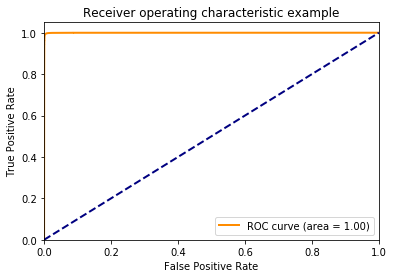

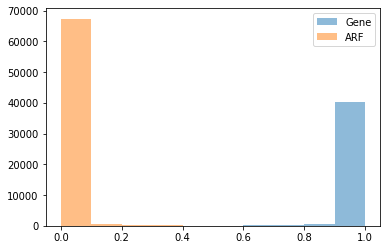

In [34]:
# evaluate new head model
def evaluate(model, X, y, BATCH_SIZE):
    model.eval()

    y_pred_list = []
    for i in range(0, len(X), BATCH_SIZE):
        if i%500==0:
            print(i, "of", len(X))
        y_pred = torch.sigmoid(model(X[i:i+BATCH_SIZE].to("cuda"))).to("cpu").detach().numpy()
        y_pred_list.append(y_pred)
    y_pred = np.concatenate(y_pred_list)
    print(y_pred.shape)

    plot_ROC(y, y_pred)
    plot_hist(y, y_pred)
    
BATCH_SIZE = 200
# total = 100000
# evaluate(genemodel, dtrain_X[:total], dtrain_y[:total], BATCH_SIZE)
# evaluate(genemodel, dvalid_X[:total], dvalid_y[:total], BATCH_SIZE)

evaluate(genemodel, dtrain_X, dtrain_y, BATCH_SIZE)
# evaluate(genemodel, dvalid_X, dvalid_y, BATCH_SIZE)


0 of 27636
1500 of 27636
3000 of 27636
4500 of 27636
6000 of 27636
7500 of 27636
9000 of 27636
10500 of 27636
12000 of 27636
13500 of 27636
15000 of 27636
16500 of 27636
18000 of 27636
19500 of 27636
21000 of 27636
22500 of 27636
24000 of 27636
25500 of 27636
27000 of 27636
(27636, 1)


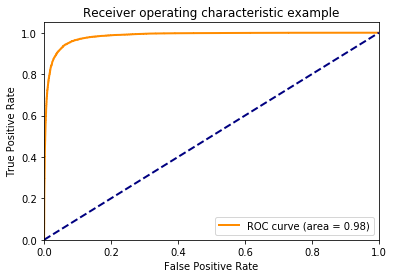

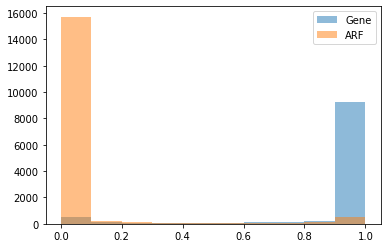

In [35]:
# evaluate new head model

def evaluate(model, X, y, BATCH_SIZE):
    model.eval()

    y_pred_list = []
    for i in range(0, len(X), BATCH_SIZE):
        if i%500==0:
            print(i, "of", len(X))
        y_pred = torch.sigmoid(model(X[i:i+BATCH_SIZE].to("cuda"))).to("cpu").detach().numpy()
        y_pred_list.append(y_pred)
    y_pred = np.concatenate(y_pred_list)
    print(y_pred.shape)

    plot_ROC(y, y_pred)
    plot_hist(y, y_pred)
    
BATCH_SIZE = 750
# total = 100000
# evaluate(genemodel, dtrain_X[:total], dtrain_y[:total], BATCH_SIZE)
# evaluate(genemodel, dvalid_X[:total], dvalid_y[:total], BATCH_SIZE)

# evaluate(genemodel, dtrain_X, dtrain_y, BATCH_SIZE)
evaluate(genemodel, dvalid_X, dvalid_y, BATCH_SIZE)
